In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install keras_preprocessing

In [3]:

!pip install tensorflow==2.17.0

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [5]:
import tensorflow as tf
print(tf.__version__)

from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras import Model
from tensorflow.keras.layers import TextVectorization, Normalization 

2.17.0


In [6]:
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [7]:
!helper_functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [9]:
dataset = "archive (4)"
walk_through_dir(dataset)

There are 12 directories and 0 images in 'archive (4)'.
There are 0 directories and 499 images in 'archive (4)\ants'.
There are 0 directories and 500 images in 'archive (4)\bees'.
There are 0 directories and 416 images in 'archive (4)\beetle'.
There are 0 directories and 434 images in 'archive (4)\catterpillar'.
There are 0 directories and 323 images in 'archive (4)\earthworms'.
There are 0 directories and 466 images in 'archive (4)\earwig'.
There are 0 directories and 485 images in 'archive (4)\grasshopper'.
There are 0 directories and 497 images in 'archive (4)\moth'.
There are 0 directories and 391 images in 'archive (4)\slug'.
There are 0 directories and 500 images in 'archive (4)\snail'.
There are 0 directories and 498 images in 'archive (4)\wasp'.
There are 0 directories and 485 images in 'archive (4)\weevil'.


In [10]:
image_dir = Path(dataset)


filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


image_df = pd.concat([filepaths, labels], axis=1)

In [11]:
len(list(image_dir.glob(r'**/*.png')))

9

In [12]:
image_df

,Filepath,Label
0,archive (4)\ants\ants (1).jpg,ants
1,archive (4)\ants\ants (10).jpg,ants
2,archive (4)\ants\ants (100).jpg,ants
3,archive (4)\ants\ants (101).jpg,ants
4,archive (4)\ants\ants (102).jpg,ants
...,...,...
10974,archive (4)\moth\moth (1).png,moth
10975,archive (4)\slug\slug (1).png,slug
10976,archive (4)\slug\slug (2).png,slug
10977,archive (4)\snail\snail (1).png,snail


In [13]:
import seaborn as sns

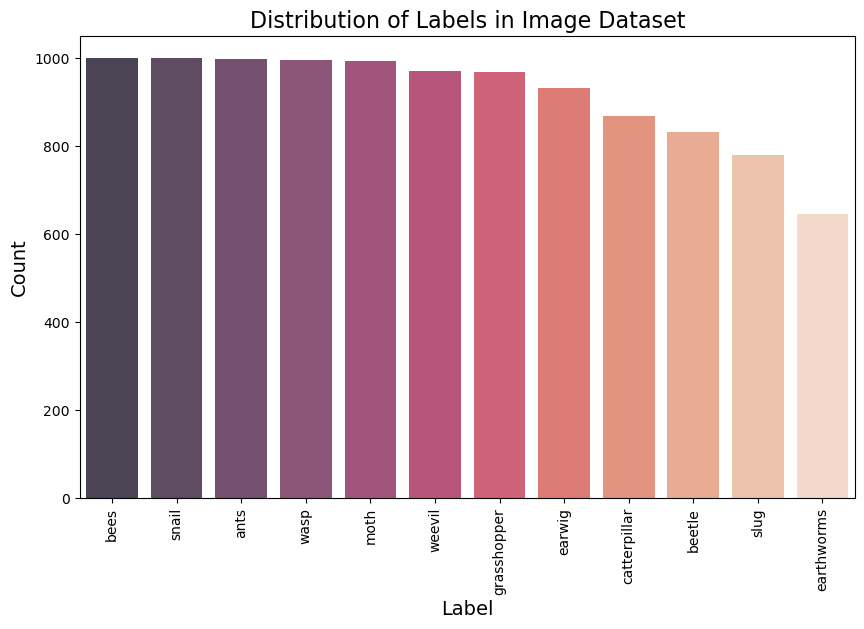

In [14]:
label_counts = image_df['Label'].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)
plt.show()

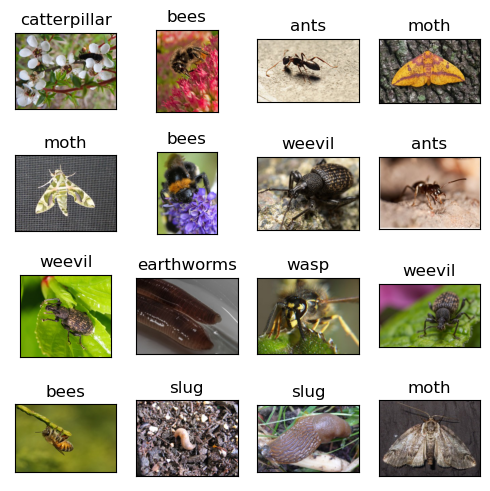

In [15]:
import matplotlib.image as mpimg
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [16]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [17]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess_input


In [18]:
train_generator = ImageDataGenerator(
    preprocessing_function=mobilenet_v3_preprocess_input,
    validation_split=0.2
)

# Create the ImageDataGenerator for testing
test_generator = ImageDataGenerator(
    preprocessing_function=mobilenet_v3_preprocess_input
)

In [19]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7027 validated image filenames belonging to 12 classes.
Found 1756 validated image filenames belonging to 12 classes.
Found 2196 validated image filenames belonging to 12 classes.


In [20]:
# xử lý ảnh chước khi đưa vào mạng neural networking
augment = tf.keras.Sequential([
    layers.Resizing(224, 224),             # Thay đổi kích thước ảnh thành 224x224 pixel.
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1), # Tái chuẩn hóa giá trị pixel vào khoảng [0, 1].
])

In [21]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [22]:
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


In [23]:

checkpoint_path = "pest_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [30]:
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=5,
                               restore_best_weights=True)

In [31]:
# Đầu vào mô hình
inputs = pretrained_model.input
x = pretrained_model.output
x = Dense(256, activation='relu')(x)#Lớp fully-connected với 256 đơn vị, kích hoạt ReLU.
x = Dropout(0.2)(x)#Dropout với tỷ lệ 20% để giảm overfitting.
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(12, activation='softmax')(x) #Lớp đầu ra với 12 đơn vị , kích hoạt softmax cho bài toán phân loại đa lớp.

In [32]:
model = Model(inputs=inputs, outputs=outputs)

In [33]:

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [42]:

log_dir = os.path.join("C:", "Data Analyts_2", "pest_classication_2")

# Huấn luyện mô hình
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        early_stopping,
        tf.keras.callbacks.TensorBoard(log_dir=log_dir),
        checkpoint_callback,
    ]
)

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 105s 474ms/step - accuracy: 0.9474 - loss: 0.1852 - val_accuracy: 0.9362 - val_loss: 0.1991
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 105s 475ms/step - accuracy: 0.9513 - loss: 0.1571 - val_accuracy: 0.9419 - val_loss: 0.1869
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 105s 473ms/step - accuracy: 0.9597 - loss: 0.1389 - val_accuracy: 0.9487 - val_loss: 0.1742
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 95s 431ms/step - accuracy: 0.9662 - loss: 0.1163 - val_accuracy: 0.9499 - val_loss: 0.1639
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 95s 430ms/step - accuracy: 0.9701 - loss: 0.1027 - val_accuracy: 0.9527 - val_loss: 0.1549
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 95s 432ms/step - accuracy: 0.9738 - loss: 0.0976 - val_accuracy: 0.9562 - val_loss: 0.1485
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 97s 439ms/step - accuracy: 0.9811 - loss: 0.0755 - val_accuracy: 0.9596 - val_loss: 0.1453
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 97s 442ms/step - accuracy: 0.978

In [43]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.12126
Test Accuracy: 96.68%


In [ ]:
#test loss  Giá trị này thể hiện mức độ sai lệch giữa dự đoán của mô hình và giá trị thực tế.
#Test Accuracy  Đây là tỷ lệ phần trăm các dự đoán đúng của mô hình trên tập dữ liệu kiểm tra

In [44]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)


labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


print(f'The first 5 predictions: {pred[:5]}')

69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 370ms/step
The first 5 predictions: ['ants', 'weevil', 'snail', 'slug', 'bees']


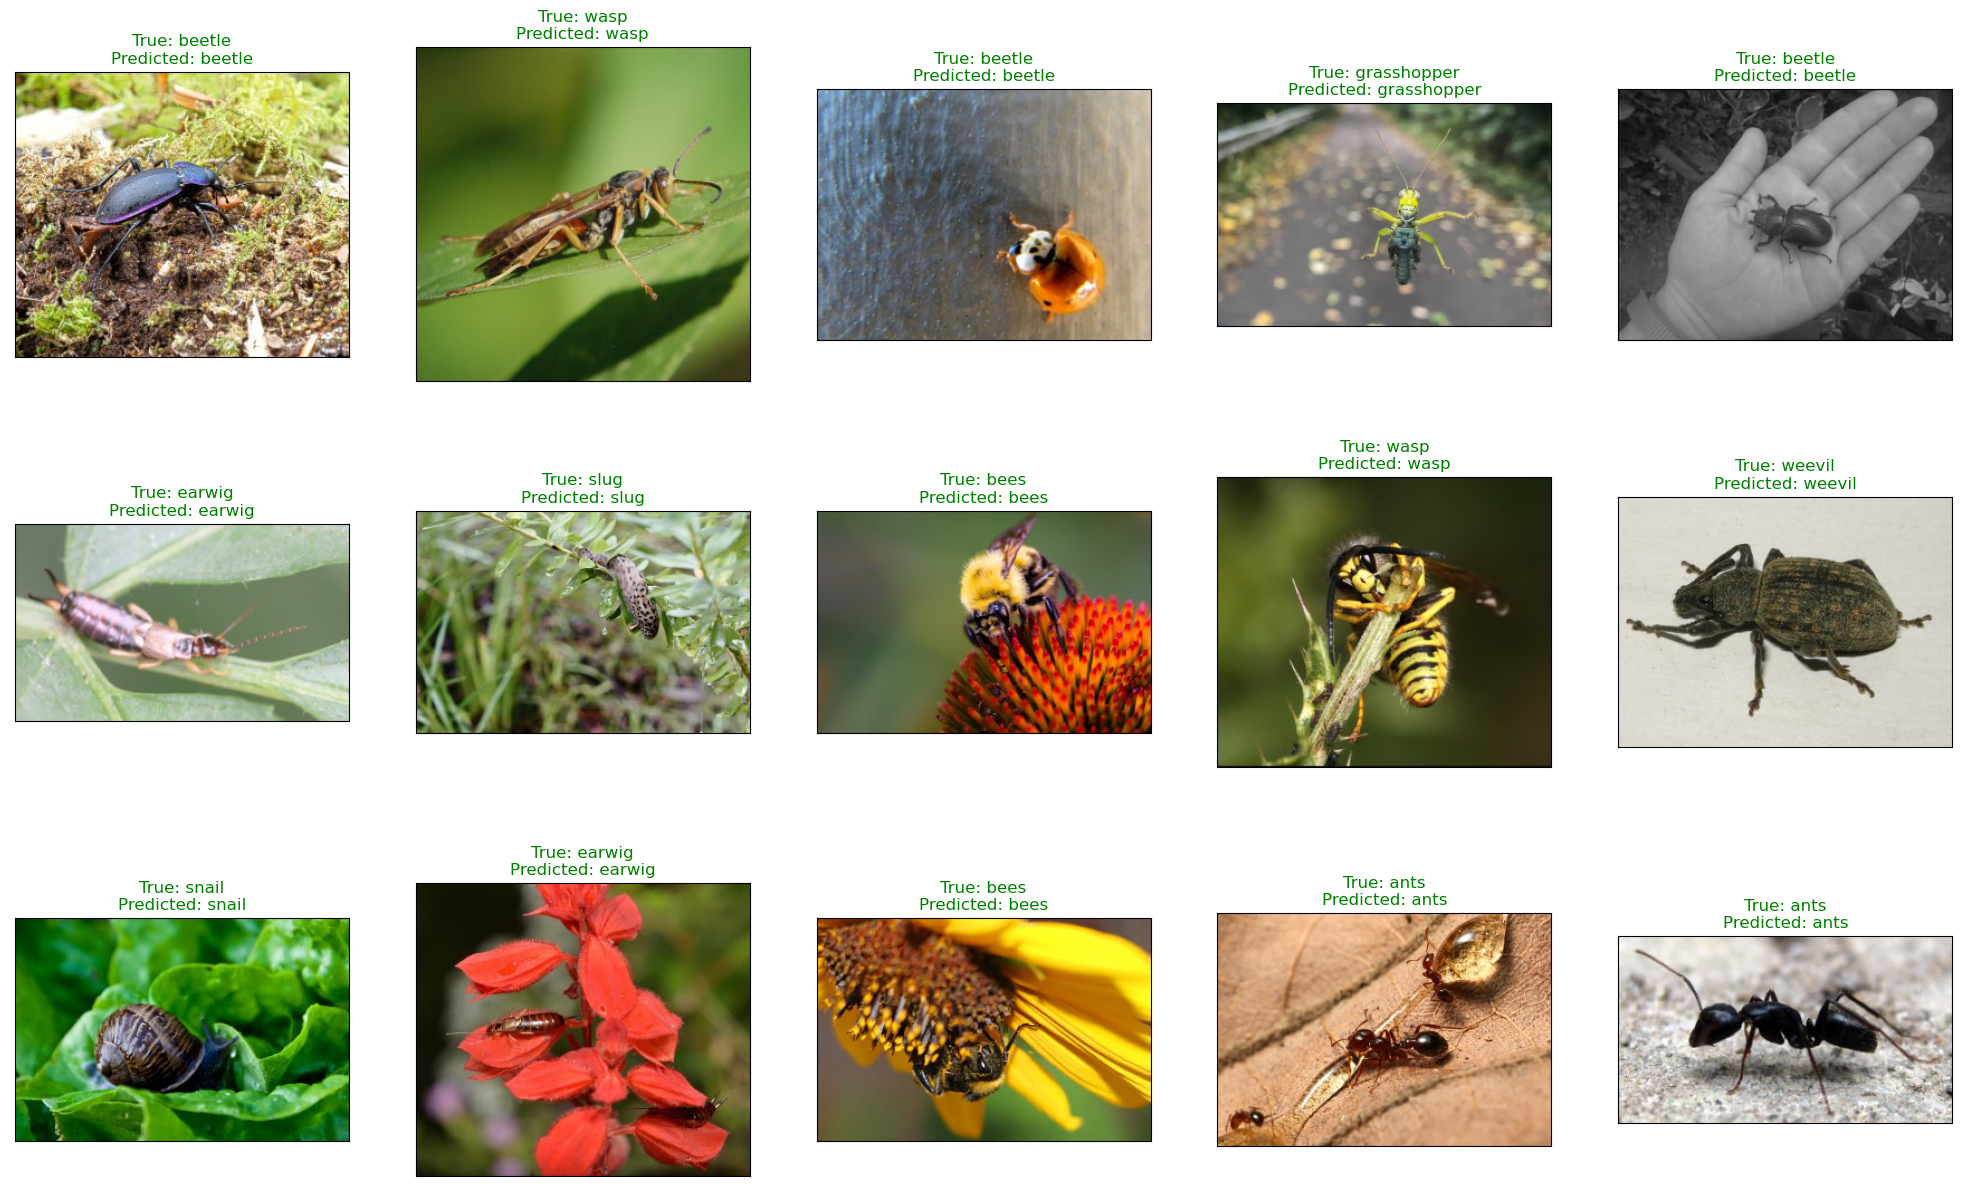

<Figure size 640x480 with 0 Axes>

In [49]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [50]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        ants       0.97      1.00      0.98       211
        bees       0.96      0.99      0.98       188
      beetle       0.93      0.89      0.91       160
catterpillar       0.91      0.95      0.93       175
  earthworms       0.95      0.94      0.94       127
      earwig       0.96      0.93      0.95       175
 grasshopper       0.96      0.97      0.96       183
        moth       0.99      1.00      0.99       221
        slug       0.98      0.94      0.96       163
       snail       0.99      1.00      1.00       202
        wasp       0.98      0.96      0.97       186
      weevil       0.99      1.00      0.99       205

    accuracy                           0.97      2196
   macro avg       0.97      0.96      0.96      2196
weighted avg       0.97      0.97      0.97      2196



In [51]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
ants,0.972222,0.995261,0.983607,211.000000
bees,0.963918,0.994681,0.979058,188.000000
beetle,0.934641,0.893750,0.913738,160.000000
catterpillar,0.912088,0.948571,0.929972,175.000000
earthworms,0.952000,0.937008,0.944444,127.000000
earwig,0.964497,0.931429,0.947674,175.000000
grasshopper,0.956757,0.967213,0.961957,183.000000
moth,0.986547,0.995475,0.990991,221.000000
slug,0.980769,0.938650,0.959248,163.000000
snail,0.990196,1.000000,0.995074,202.000000
